# 1: Multilayer Perceptrons

# Activation functions

### Relu

$$ReLU(x) = \max(x, 0)$$

In [5]:
%matplotlib inline
import torch
from d2l import torch as d2l

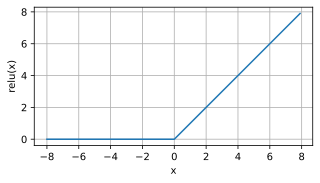

In [6]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)

d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))

At $0$, the derivate is said to be $0$.

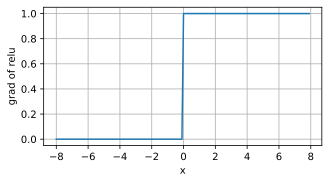

In [7]:
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

$$pReLU(x) = \max{(0, x)} + \alpha \min{(0, x)}$$

### Sigmoid function

$$sigmoid(x) = \frac{1}{1 + e ^{-x}}$$
And the codomain is $[0, 1]$.

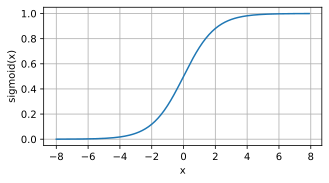

In [8]:
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

Where the derivative is given by 
$$sigmoid(x)(1-sigmoid(x))$$

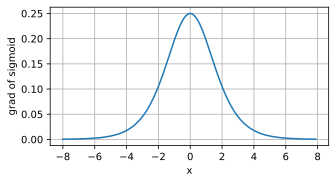

In [9]:
#Clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

### Hyperbolic tangent

$$tanh(x) = \frac{1 - e^{-2x}}{1+e^{-2x}}\in [0, 1]$$

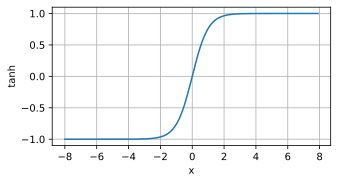

In [10]:
y = torch.tanh(x)
d2l.plot(x.detach(), y.detach(), 'x', 'tanh', figsize=(5, 2.5))

$$\frac{d}{dx}tanh(x) = 1- tanh^2(x)$$

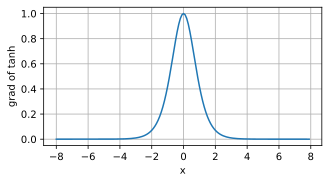

In [11]:
x.grad.data.zero_()
y.backward(torch.ones_like(x), retain_graph=True)

d2l.plot(x.detach(), x.grad, 'x', 'grad of tanh', figsize=(5, 2.5))

# 2: Implementation of Multilayer Perceptrons

In [12]:
import torch
from torch import nn
from d2l import torch as d2l

## Implementation from scratch

We usually disregard spatial structure, so for example we linearize the shape of images.  
We choose layer widths to be divisible by 2. Remember that for each layer, we need to keep tracks of weights and biases.  

Let's start with a single, 256-parameters hidden layer.

### Initialization

In [13]:
class MLPScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma = 0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.b1 = nn.Parameter(torch.zeros(num_hiddens))
        self.W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs) * sigma)
        self.b2 = nn.Parameter(torch.zeros(num_outputs))

### Model

In [14]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

In [15]:
#disregarding spatial structure
@d2l.add_to_class(MLPScratch)
def forward(self, X):
    X = X.reshape((-1, self.num_inputs))
    H = relu(torch.matmul(X, self.W1) + self.b1)
    return torch.matmul(H, self.W2) + self.b2

### Training

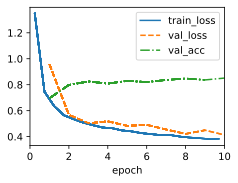

In [16]:
model = MLPScratch(num_inputs=784, num_hiddens=256, num_outputs=10, lr = 0.1)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

## Coincise implementation

In [17]:
#Model
#We add two fully connected layers: hidden and output

class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), nn.LazyLinear(num_outputs))
        
#Sequential abstracts out the forward() method

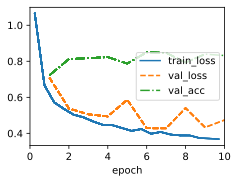

In [18]:
#Training
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer.fit(model, data)

# 4: Numerical stability and initialization

Initizalization plays a key role in training and it can be bound to the the decision of the nonlinear activation function.

In [19]:
%matplotlib inline
import torch
from d2l import torch as d2l

## Vanishing and exploding gradients

See chapter 5.4.1

Gradients often vanish because of the non-linear activation function $\sigma$.  
Think about very large or small values of a sigmoid function.

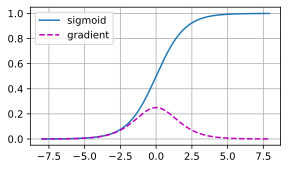

In [20]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))

d2l.plot(x.detach(), [y.detach(), x.grad],
         legend=['sigmoid', 'gradient'], figsize=(4.5, 2.5))

Thus, ReLU have emerged.

In [21]:
#Exploding gradients

M = torch.normal(0, 1, size=(4, 4))
print('a single matrix \n', M)
for i in range(100):
    M = M@ torch.normal(0, 1, size=(4, 4))

print('after multiplying 100 matrices \n', M)

a single matrix 
 tensor([[-1.0908, -0.5458, -0.1546, -0.1299],
        [-0.5265, -2.4079,  0.2624, -1.2716],
        [ 1.4497,  0.0705, -1.1385,  1.3024],
        [ 1.5995, -0.6155,  0.1790, -0.6617]])
after multiplying 100 matrices 
 tensor([[-1.0519e+24, -3.2204e+24,  2.0800e+24,  1.3105e+24],
        [ 3.0959e+23,  9.4780e+23, -6.1217e+23, -3.8570e+23],
        [ 3.2492e+24,  9.9472e+24, -6.4248e+24, -4.0480e+24],
        [ 2.0013e+24,  6.1270e+24, -3.9574e+24, -2.4934e+24]])


Another problem is the symmetry of neural network design.

Permuting all the weights corresponds to having the same outputs.  
Moreover, taking the example of a single-output, two-elements single hidden layer unit, initializing all the hidden elements to the same value will inevitably make them take always the same values. **Nothing will break the simmetry**.

## Parameter initilization

All of this problems can be addressed by tweaking the parameter initialization.

### Xavier initialization

Consider a network without nonlinearities. In order to avoid the vector (forward pass) values and the gradients (backpropagagtion) values to explode, we need to **keep the variance of their initialization low** as follows:
$$\sigma = \sqrt{\frac{2}{n_{in} + n_{out}}}$$

with $\sigma$ being the std of weights, and $n$ the number of inputs and ouputs.  
This requires *all weights and tensors to be independent of each other*.  

This initialization method works well even with non-linear activation functions.

# 6: Dropout

A good model should not be sensitive to outliers, and in classical learning, this is formalized by the fact that training with noisy inputs is equaivalent to a specific kind of regularization.  
The dropout method brings this idea to the internal layers of a deep neural network by *dropping out* (i.e., setting to zero) some neurons in each iteration.

This is done in practice by replacing each $h$ with
$$h' = \begin{cases}
0\\
\frac{h}{1-p}
\end{cases}$$

With the first one having *dropout probability $p$*.  
The term $1-p$ is needed to **debias** each layer by renormalizing.  
In this way, $$E(h') = h$$

Observe that this practice removes the possibility that a layer's ouput is overly-dependent on a single neuron.  
Usually at test time dropout is deactivated; but it is useful to see that if *preditictions agree across various dropouts, the network is said to be more confident*.

## Dropout in practice

It is modeled as a Bernoulli trial: 1 with probability 1-p for keeping and 0 with probability p for dropping. We perform as many Bernoulli trials as the number of dimensions.  
It makes sense to set **lower dropout probabilities near the input layer**.

In [22]:
import torch
from torch import nn
from d2l import torch as d2l

In [23]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1: return torch.zeros_like(X)
    tmp = torch.rand(X.shape)       #this returns a matrix with values between 0 and 1
    mask = (tmp>dropout).float()
    #print(tmp)
    #print(mask)
    return mask * X / (1.0-dropout)

In [24]:
#A few tests
X = torch.arange(16, dtype=torch.float32).reshape((2, 8))
print('dropout_p = 0: ', dropout_layer(X, 0))
print('dropout_p = 0.5: ', dropout_layer(X, 0.5))
print('dropout_p = 1: ', dropout_layer(X, 1))

dropout_p = 0:  tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
dropout_p = 0.5:  tensor([[ 0.,  0.,  0.,  6.,  8., 10., 12.,  0.],
        [16.,  0.,  0.,  0.,  0., 26.,  0., 30.]])
dropout_p = 1:  tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [25]:
#Model
#We apply dropout after the activation of each hidden layer

class DropoutMLPScratch(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.lin1 = nn.LazyLinear(num_hiddens_1)
        self.lin2 = nn.LazyLinear(num_hiddens_2)
        self.lin3 = nn.LazyLinear(num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((X.shape[0], -1))))
        if self.training:
            H1 = dropout_layer(H1, self.dropout_1)
        H2 = self.relu(self.lin2(H1))
        if self.training:
            H2 = dropout_layer(H2, self.dropout_2)
        return self.lin3(H2)

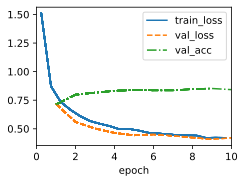

In [26]:
#Training

hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.5, 'lr':0.1}
model = DropoutMLPScratch(**hparams)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

In [27]:
#Coincise implementation

class DropoutMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(num_hiddens_1),
            nn.ReLU(),
            nn.Dropout(dropout_1),
            nn.LazyLinear(num_hiddens_2),
            nn.ReLU(),
            nn.Dropout(dropout_2),
            nn.LazyLinear(num_outputs)
        )

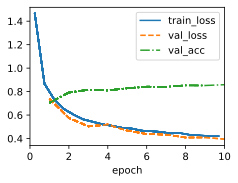

In [28]:
#Training 

model = DropoutMLP(**hparams)
trainer.fit(model, data)

# Predicting House Prices with Kaggle

In [2]:
%matplotlib inline
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
class KaggleHouse(d2l.DataModule):
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            self.raw_train = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_train.csv', self.root,
                sha1_hash= '585e9cc93e70b39160e7921475f9bcd7d31219ce'
            ))

            self.raw_val = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_test.csv', self.root,
                sha1_hash='fa19780a7b011d9b009e8bff8e99922a8ee2eb90'
            ))

In [4]:
data = KaggleHouse(batch_size=64)
print(data.raw_train.shape)
print(data.raw_val.shape)

(1460, 81)
(1459, 80)


## Preprocessing Data

In [5]:
print(data.raw_train.iloc[:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


First, we replace all missing values with the feature's mean, and then we standardize data. We also remove the id column, since it is useless for regression.

Then, each categorical feature is transformed with *one-hot encoding*:
we replace a column with as many columns as the number of categories it can take, and then each of this column can accept a boolean value.

In [6]:
@d2l.add_to_class(KaggleHouse)
def preprocess(self):
    #Remove the ID and label columns
    label = 'SalePrice'
    features = pd.concat(
        (self.raw_train.drop(columns=['Id', label]),
         self.raw_val.drop(columns=['Id']))
    )
    #Standardize numerical columns
    numeric_features = features.dtypes[features.dtypes !='object'].index
    features[numeric_features] = features[numeric_features].apply(
        lambda x: (x - x.mean()) / (x.std())
    )
    #Replace NAN numerical features by 0 (???)
    features[numeric_features] = features[numeric_features].fillna(0)
    #Replace features with one-hot encoding
    features = pd.get_dummies(features, dummy_na=True)
    #Save preprocessed features
    self.train = features[:self.raw_train.shape[0]].copy()
    self.train[label] = self.raw_train[label]
    self.val = features[self.raw_train.shape[0]:].copy()

In [7]:
data.preprocess()
data.train.shape

(1460, 331)

## Error measure

Let's start things off with a linear model, just to see how close it gets to deep neural networks.  
We are more interested in the relative error $\frac{y-\hat{y}}{y}$ than the absolute error.  
In order to obtain this, the logarithm of the price estimates is employed:
$$|\log{y} - \log{\hat{y}} \leq \delta$$
$$e^{-\delta} \leq \frac{\hat{y}}{y} \leq e^{\delta}$$
from which the root-mean square error metric arises:
$$\sqrt{\frac{1}{N}\sum_{i=1}^{N}(\log{y_i}-\log{\hat{y_i}})^2}$$

In [8]:
@d2l.add_to_class(KaggleHouse)
def get_dataloader(self, train):
    label = 'SalePrice'
    data = self.train if train else self.val
    if label not in data: return
    get_tensor = lambda x: torch.tensor(x.values.astype('float'),
                                        dtype = torch.float32)
    
    #Logarithm of the prices
    tensors = (get_tensor(data.drop(columns = [label])),
               torch.log (get_tensor(data[label])).reshape((-1, 1)))
    
    return self.get_tensorloader(tensors, train)